# Data Exploration

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import requests

import warnings
warnings.filterwarnings('ignore')

In [10]:
unique_df = pd.read_csv("../data/unique_austin_shelter.csv")

In [11]:
unique_df.set_index("animal_id", inplace=True)

---

In [5]:
import folium
from folium import plugins

In [8]:
m = folium.Map([30.2672, -97.7431], zoom_start=11)
m

## Average time in shelter

In [6]:
(unique_df.date_out.apply(pd.to_datetime) - unique_df.date_in.apply(pd.to_datetime)).mean()

Timedelta('15 days 12:19:14.942563')

In [7]:
(unique_df.date_out.apply(pd.to_datetime) - unique_df.date_in.apply(pd.to_datetime)).max()

Timedelta('1026 days 21:15:00')

In [8]:
(unique_df.date_out.apply(pd.to_datetime) - unique_df.date_in.apply(pd.to_datetime)).min()

Timedelta('0 days 00:01:00')

## Most common dog name

In [9]:
unique_df.name.value_counts().head()

Bella    271
Max      258
Daisy    203
Luna     193
Rocky    187
Name: name, dtype: int64

## How many dogs don't have names

In [10]:
unique_df.name.isnull().value_counts()

False    31897
True      8212
Name: name, dtype: int64

## Where were the most dogs found?

**Not on the most current data**

## Number of dogs per outcome type

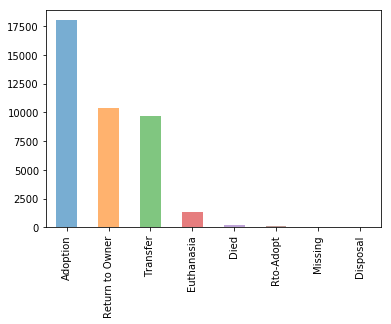

In [75]:
unique_df.outcome_type.value_counts().plot.bar(alpha=0.6)

In [76]:
unique_df.outcome_type.value_counts()

Adoption           17996
Return to Owner    10343
Transfer            9650
Euthanasia          1349
Died                 168
Rto-Adopt            164
Missing               12
Disposal              12
Name: outcome_type, dtype: int64

## Does intake conditon affect outcome?

In [131]:
intake_counts = pd.crosstab(unique_df.intake_condition, unique_df.outcome_type)
intake_counts_df = intake_counts / intake_counts.sum()
intake_counts_df

outcome_type,Adoption,Died,Disposal,Euthanasia,Missing,Return to Owner,Rto-Adopt,Transfer
intake_condition,,,,,,,,
Aged,0.002667,0.023810,0.00,0.038547,0.000000,0.010635,0.006098,0.004560
Feral,0.000111,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000622
Injured,0.032007,0.226190,0.25,0.243143,0.083333,0.032292,0.060976,0.053368
Normal,0.937542,0.458333,0.50,0.564122,0.750000,0.945084,0.908537,0.859482
Nursing,0.013781,0.101190,0.00,0.005189,0.083333,0.002901,0.000000,0.024560
Other,0.001667,0.000000,0.00,0.007413,0.000000,0.001934,0.000000,0.003731
Pregnant,0.000667,0.000000,0.00,0.000000,0.000000,0.000290,0.000000,0.001762
Sick,0.011558,0.190476,0.25,0.141586,0.083333,0.006865,0.024390,0.051917


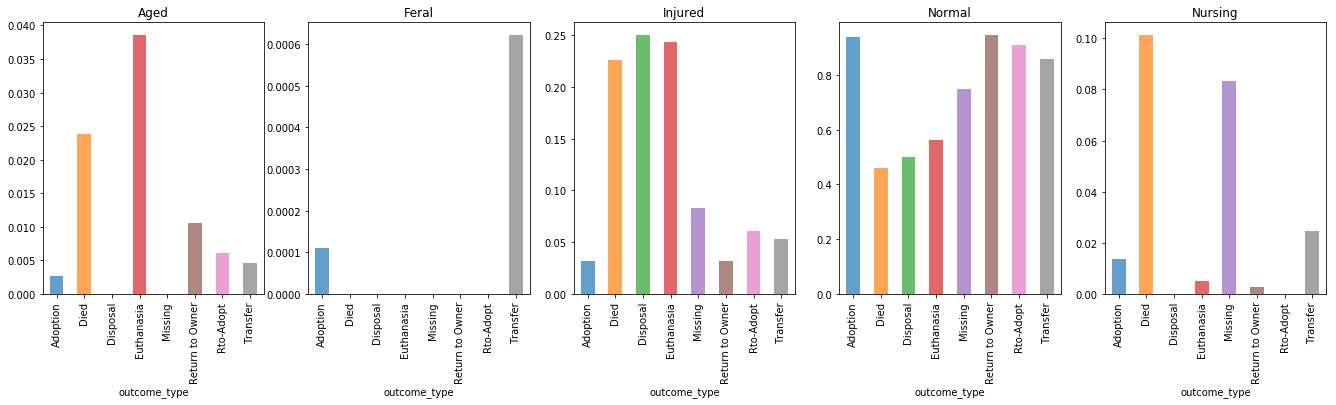

In [120]:
fig, axes = plt.subplots(1, 5, figsize=(23, 5))

intake_cnds = intake_counts_df.index.unique()
for ax, intake_cnd in zip(axes, intake_cnds):
    intake_counts_df.loc[intake_cnd].plot.bar(alpha=0.7, ax=ax)
    ax.set_title(intake_cnd)

## Are injured or sick dogs more likely to be euthanized than healthy dogs?

In [155]:
euth_counts = pd.crosstab(unique_df.intake_condition,(unique_df.outcome_type=="Euthanasia"))
euth_counts

outcome_type,False,True
intake_condition,,
Aged,208,52
Feral,8,0
Injured,1506,328
Normal,35540,761
Nursing,554,7
Other,86,10
Pregnant,34,0
Sick,824,191


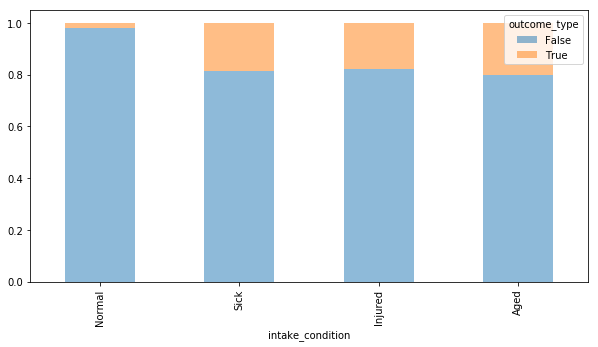

In [156]:
euth_counts_sum = euth_counts.sum(axis=1)
euth_given_intake = euth_counts.divide(euth_counts_sum, axis=0)
euth_given_intake.loc[['Normal', 'Sick', "Injured", "Aged"]].plot.bar(stacked=True, alpha=0.5, figsize=(10,5))

## Which intake condition gets a dog adopted the most?

In [127]:
adoption_counts = pd.crosstab(unique_df.intake_condition,(unique_df.outcome_type=="Adoption"))
adoption_counts

outcome_type,False,True
intake_condition,,
Aged,212,48
Feral,6,2
Injured,1258,576
Normal,19429,16872
Nursing,313,248
Other,66,30
Pregnant,22,12
Sick,807,208


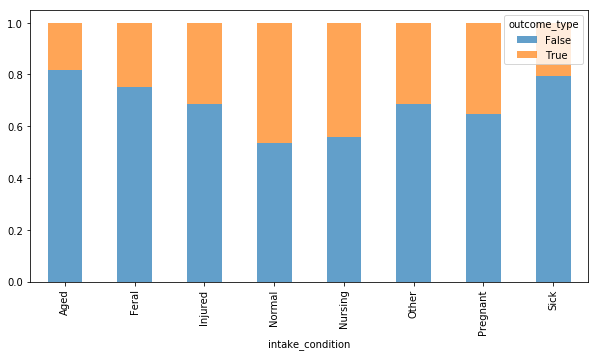

In [157]:
adopt_counts_sum = adoption_counts.sum(axis=1)
adopt_given_intake = adoption_counts.divide(adopt_counts_sum, axis=0)
adopt_given_intake.plot.bar(stacked=True, alpha=0.7, figsize=(10,5))

## Does the outcome of a dog change based on gender?

In [130]:
sex_counts = pd.crosstab(unique_df.outcome_type, unique_df.sex)
sex_counts

sex,Female,Male
outcome_type,,
Adoption,8860,9135
Died,74,78
Disposal,4,6
Euthanasia,567,749
Missing,6,6
Return to Owner,4382,5919
Rto-Adopt,66,98
Transfer,4634,4908


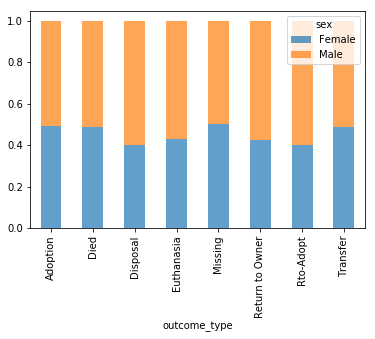

In [158]:
sex_counts_sum = sex_counts.sum(axis=1)
outcome_given_sex = sex_counts.divide(sex_counts_sum, axis=0)
outcome_given_sex.plot.bar(stacked=True, alpha=0.7)

## What are the top 20 abandoned dog breeds?

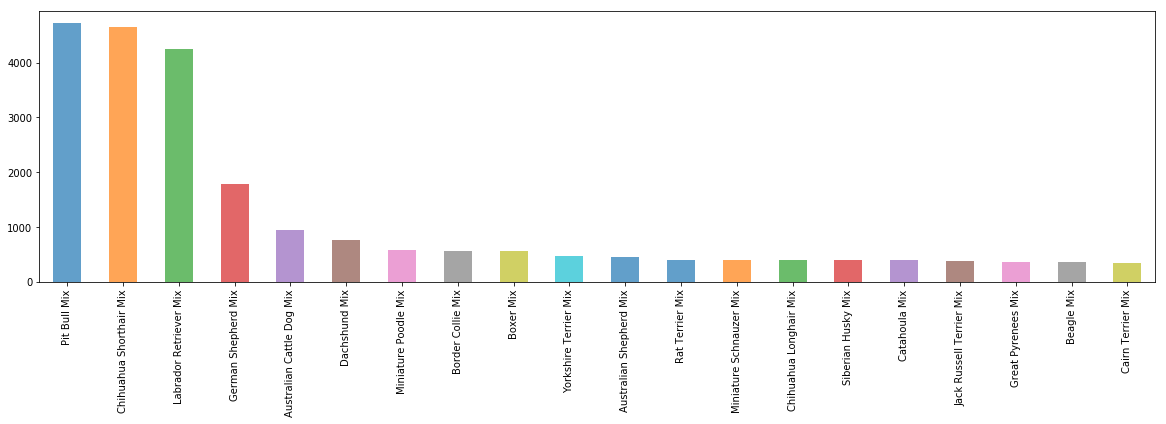

In [141]:
unique_df.breed.value_counts()[:20].plot.bar(figsize=(20,5), alpha=0.7)

## What are the top 20 adopted dog breeds?

In [142]:
unique_df.loc[(unique_df.in_shelter == "No") 
              & (unique_df.outcome_type=="Adoption")].breed.value_counts()[:10]

Chihuahua Shorthair Mix      2150
Labrador Retriever Mix       2139
Pit Bull Mix                 1725
German Shepherd Mix           863
Australian Cattle Dog Mix     512
Dachshund Mix                 361
Border Collie Mix             317
Boxer Mix                     244
Miniature Poodle Mix          237
Australian Shepherd Mix       225
Name: breed, dtype: int64

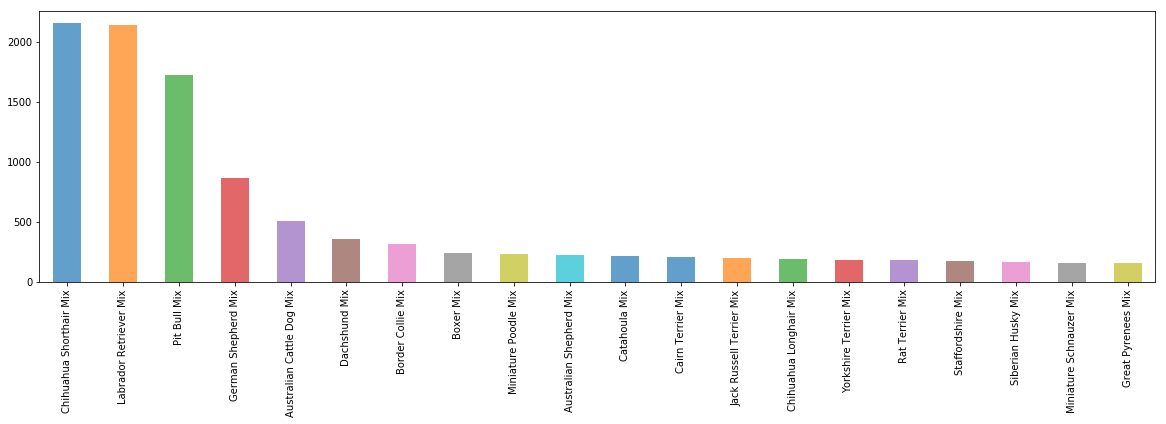

In [144]:
(unique_df.loc[(unique_df.in_shelter == "No") & (unique_df.outcome_type=="Adoption")]
                 .breed.value_counts()[:20].plot.bar(figsize=(20,5), alpha=0.7))

## What is the most common time a dog is admitted?

In [23]:
unique_df.date_in = unique_df.date_in.apply(pd.to_datetime)

In [24]:
months = [1,2,3,4,5,6,7,8,9,10,11,12]
years = [2014,2015,2016,2017,2018]

In [25]:
admission_by_month = pd.DataFrame(index=months , columns=years)

In [26]:
for year in years:
    for month in months:
        temp = unique_df.date_in.apply(lambda x: (x.month==month) & (x.year==year)).value_counts()
        admission_by_month.loc[month,year] = temp[1]

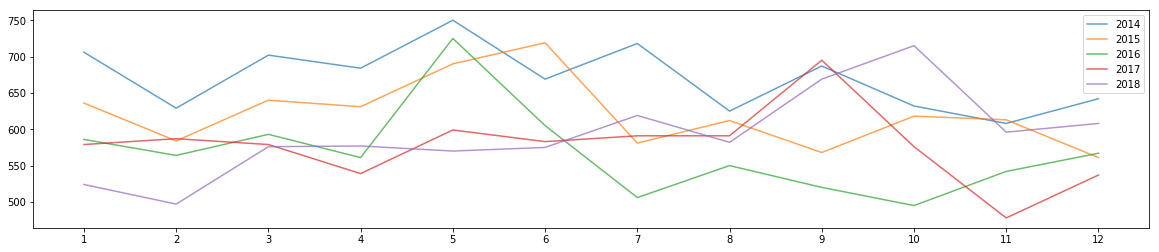

In [28]:
admission_by_month.plot.line(xticks=months, figsize=(20,4),alpha=0.7)

## What is the most common time a dog is adopted?

In [30]:
unique_df.date_out = unique_df.date_out.apply(pd.to_datetime)

In [31]:
months = [1,2,3,4,5,6,7,8,9,10,11,12]
years = [2014,2015,2016,2017,2018]

In [32]:
adoption_by_month = pd.DataFrame(index=months , columns=years)

In [33]:
for year in years:
    for month in months:
        
        temp = unique_df[unique_df.outcome_type=="Adoption"].date_in.apply(lambda x: (x.month==month) & (x.year==year)).value_counts()
        
        adoption_by_month.loc[month,year] = temp[1]

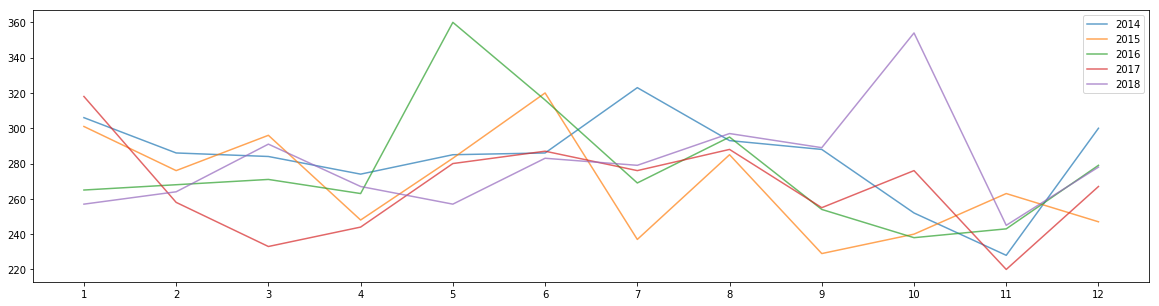

In [35]:
adoption_by_month.plot.line(xticks=months, figsize=(20,5),alpha=0.7)

## What is the most common age a dog is admitted?

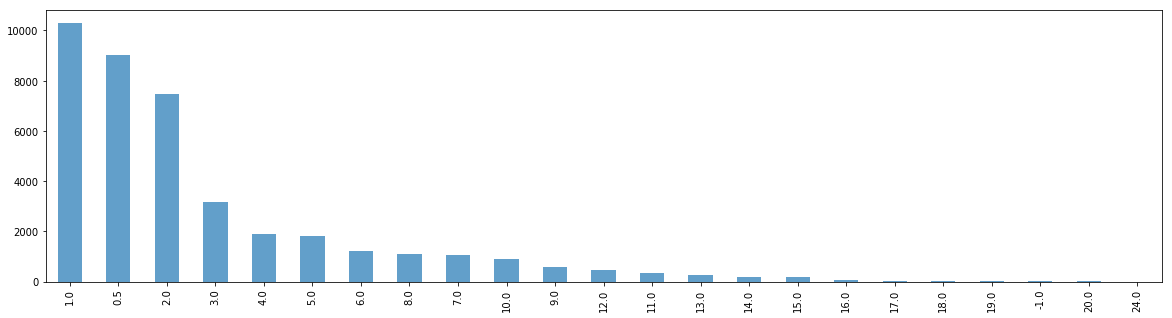

In [16]:
unique_df.age_in.apply(round).replace(0, 0.5).value_counts().plot.bar(figsize=(20,5),alpha=0.7)

## What is the most common age a dog is adopted?

In [153]:
age_counts = pd.crosstab(unique_df.age_in, unique_df.age_out)

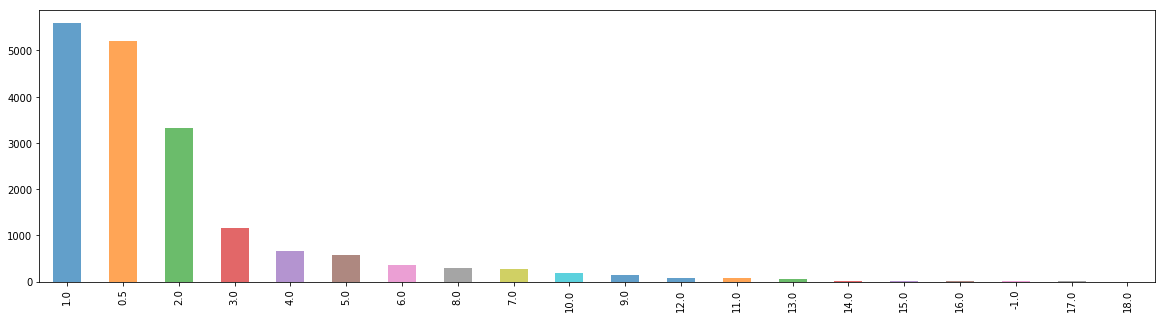

In [147]:
unique_df.loc[unique_df.outcome_type == "Adoption"]['age_out'].value_counts().plot.bar(figsize=(20,5),alpha=0.7)

## What is the best age to abandon your dog to ensure that it will be adopted?

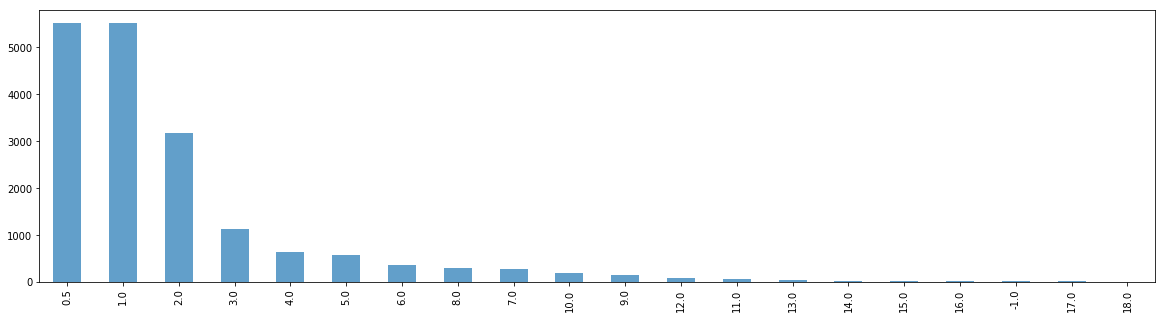

In [17]:
unique_df.loc[unique_df.outcome_type == "Adoption"]['age_in'].apply(round).replace(0, 0.5).value_counts().plot.bar(figsize=(20,5),alpha=0.7)

## How many surrendered dogs were returned to their owners?

In [67]:
returned_dogs = ((unique_df.intake_type=="Owner Surrender")
                 &(unique_df.outcome_type=="Return to Owner"))

returned_dogs.value_counts()

False    39716
True       393
dtype: int64

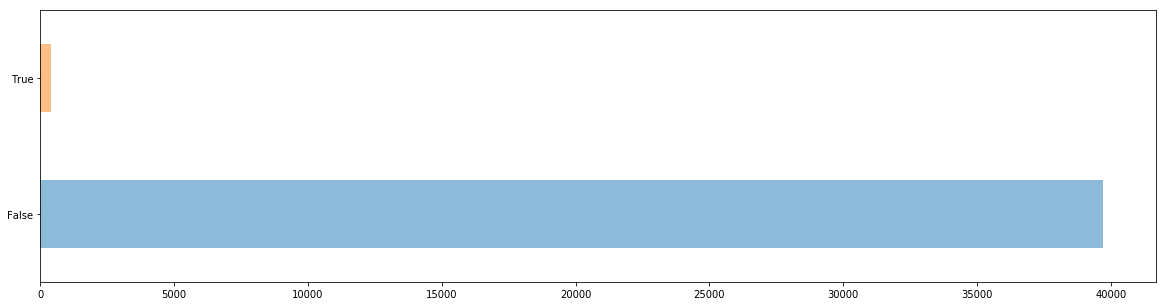

In [68]:
returned_dogs.value_counts().plot.barh(alpha=0.5,figsize=(20,5))

In [70]:
unique_df[returned_dogs].time_in_shelter.max()

'98 days 03:32:00.000000000'

In [71]:
unique_df[returned_dogs].time_in_shelter.min()

'0 days 00:09:00.000000000'